In [1]:
import sys
sys.path.append('../bin')

In [25]:
from ParentChildMutate import *
from MutationRankingResults import *
from RefSeqMutate import *

In [3]:
import os
os.chdir('..')

## Parent-Child Experiment

In [4]:
mutate_parents_kwargs = {
    'alpha':1.5, 
    'beta':3.0, 
    'gamma':1.0
}
pc = ParentChildMutateExp(tree_version=1, finetuned=True, forward_mode=True, l1_change=False,
                                         data_folder='data/processed/ncbi_tree_v1/')

# if results have been downloaded load_previous loads the results without re-calculating
pc.run_experiment(include_change=True, include_attn=True, csv=True, load_previous=True, 
                 mutate_parents_kwargs = mutate_parents_kwargs
                 )


logs/protbert_ft_v1/version_2/checkpoints/epoch=3-step=91.ckpt
loading tree data
data/processed/ncbi_tree_v1//exp_settings/mutation_data.pkl
prepping parent child


../bin\ParentChildMutate.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.new_mutations['pos'] = self.new_mutations['pos'].astype(int)


Total Unique Parent Sequences: 360
checking saved attention changes
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_attn_ft.pkl
checking saved probabilities
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_forward_prob_ft.pkl
checking saved embedding change
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_l2_change_ft.pkl


In [5]:
measures = ['prob_auc','change_auc','attn_auc','cscs_auc','dnms_auc']


In [6]:
avg = pc.results[(pc.results['result_type']=='Solo Mutation')][measures].mean()

In [7]:
print('Global Average')
print(avg)

Global Average
prob_auc      0.696078
change_auc    0.668008
attn_auc      0.657164
cscs_auc      0.729998
dnms_auc      0.735994
dtype: float64


In [8]:
print("Average per threshold")
avg1 = pc.results_summary[measures].mean()
print(avg1)

Average per threshold
prob_auc      0.729810
change_auc    0.761710
attn_auc      0.788440
cscs_auc      0.794838
dnms_auc      0.822806
dtype: float64


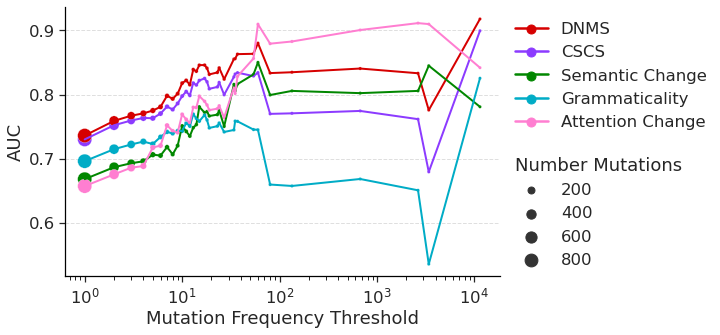

In [9]:
plot_thresholds(pc.results_summary)

In [10]:
r = pc.results[(pc.results['result_type']=='Solo Mutation')]

In [11]:
# mutation G339H in all parent sequences are D339H
voi_muts = ['F486P', 'F486V', 'G339H', 'K444T', 'N460K']

In [12]:
#R439T (mapped mutation is K444T) is excluded to focus on K->T mutations in parent set
#F4839 (mapped mutation is F486P) is excluded to focus on S->P mutations in parent set
excl = ['R439T', 'F483P']

In [13]:
df = r[(r['ref_muts'].isin(voi_muts)) & ~(r['muts'].isin(excl))].groupby('ref_muts')[measures].mean().reset_index()

In [14]:
df1 = pd.melt(df, id_vars=['ref_muts'], value_vars=measures)

In [15]:
muts_names = {'K444T': 'K444T', 'N460K': 'N460K', 'G339H': 'D339H', 'F486P': 'S486P', 'F486V': 'F486V'}

In [16]:
df1['mutation'] = df1['ref_muts'].map(muts_names)

In [17]:
df1['variable'] = df1['variable'].replace({'dnms_auc':'DNMS',
                                         'cscs_auc':'CSCS',
                       'change_auc':'Semantic Change',
                       'prob_auc':"Grammaticality",
                        'attn_auc':'Attention Change'})

In [18]:
hue_order =['Grammaticality','Semantic Change','Attention Change','CSCS','DNMS']

In [19]:
n = len(set(df1['variable']))
#palette = sns.color_palette("crest", n)
palette = sns.color_palette("crest", n*3)
palette = palette[1::3]
muts = ['D339H','K444T', 'N460K', 'S486P',   'F486V' ]
labels = ['Grammaticality','Semantic Change','Attention Change','CSCS','DNMS']
order = [0, 1, 2, 3, 4]
mapped = dict(zip(labels, order))
df1['order'] = df1['variable'].map(mapped)
df1 = df1.sort_values('order')
mut_data = {}
for m in muts:
    m_data = df1[(df1['mutation']==m)]
    m_data = m_data.sort_values('order')
    mut_data[m] = m_data

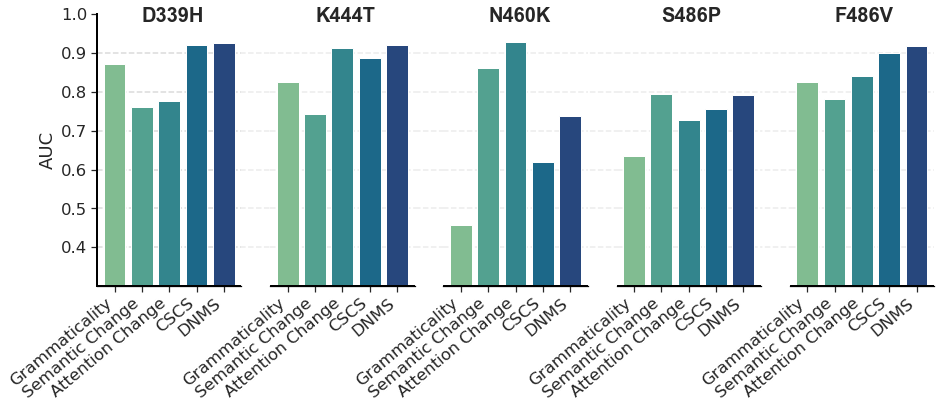

In [20]:


fig, axes = plt.subplots(1, 5, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)

for i, ax in enumerate(axes.flat):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0.3, 1.0])
    if i == 0:
        y_ticks = ax.get_yticks()
        ax.spines['left'].set_linewidth(2)
    if i > 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    mut = muts[i]
    m_data = mut_data[mut]
    ax.bar(m_data['variable'], m_data['value'], color=palette, zorder=20)
    #ax.title.set_text(mut)
    ax.annotate(mut, xy=(1, .98), fontsize=20, fontweight='bold', fontfamily='sans-serif')
    values_list = ax.get_xticks()
    ax.set_xticks(values_list)
    ax.set_xticklabels(labels, rotation=40, ha='right')
    for y_tick in y_ticks[1:-1]:
        ax.axhline(y_tick, color='gray',  zorder=0, alpha=0.15, ls='dashed')
    ax.axhline(y_ticks[0], color='black', zorder=30, linewidth=3)
axes[0].set_yticks(y_ticks[1:])
axes[0].set_ylabel('AUC')

for y_tick in y_ticks[1:-1 ]:
    axes[0].axhline(y = y_tick, xmin=0, xmax=5, clip_on = False, 
                ls='dashed', zorder=0, color='gray', alpha=0.15, snap=True)

plt.show();


## Reference Sequence Experiment

In [21]:
ranking_values = {'alpha':1.5, 'beta':3.0, 'gamma':1.0}
ref = RefSeqMutateExp(tree_version=1, finetuned=True, forward_mode=True, l1_change=False,
                                         data_folder='data/processed/ncbi_tree_v1/')

# if results have been downloaded load_previous loads the results without re-calculating
ref.run_experiment(include_change=True, include_attn=True, csv=True, load_previous=True, 
                 mutate_parents_kwargs=ranking_values)

logs/protbert_ft_v1/version_2/checkpoints/epoch=3-step=91.ckpt
loading tree data
data/processed/ncbi_tree_v1//exp_settings/mutation_data.pkl
prepping parent child


../bin\ParentChildMutate.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.new_mutations['pos'] = self.new_mutations['pos'].astype(int)


checking saved attention changes
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_attn_ft.pkl
checking saved probabilities
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_forward_prob_ft.pkl
checking saved embedding change
previous saved values found
data/processed/ncbi_tree_v1//tree_v1_seq_l2_change_ft.pkl


In [22]:
measures = ['prob_auc','change_auc','attn_auc','cscs_auc','dnms_auc']
avg = ref.results[(ref.results['result_type']=='Solo Mutation')][measures].mean()

In [23]:
print('Global Average')
print(avg)

Global Average
prob_auc      0.660620
change_auc    0.633769
attn_auc      0.610493
cscs_auc      0.692255
dnms_auc      0.697432
dtype: float64


In [24]:
print("Average per threshold")
avg1 = ref.results_summary[measures].mean()
print(avg1)

Average per threshold
prob_auc      0.645842
change_auc    0.593482
attn_auc      0.667015
cscs_auc      0.667472
dnms_auc      0.692288
dtype: float64
